# 제품 이상여부 판별 프로젝트

## 1. 데이터 불러오기


### 필수 라이브러리


In [35]:
import os
from pprint import pprint
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

# plotly
import plotly
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### 데이터 읽어오기


In [3]:
ROOT_DIR = "data"
RANDOM_STATE = 110

# Load data
train = pd.read_csv(os.path.join(ROOT_DIR, "train_junhyeok.csv"))
test = pd.read_csv('./data/test_junhyeok.csv')

### 필요하거나 묶일 수 있는 변수 가져오기

In [4]:
# 이 셀은 한번만 클릭
train['Equipment_Dam'] = train['Equipment_Dam'].str.slice(15, 16)
train['Equipment_Fill1'] = train['Equipment_Fill1'].str.slice(17, 18)
train['Equipment_Fill2'] = train['Equipment_Fill2'].str.slice(17, 18)

test['Equipment_Dam'] = test['Equipment_Dam'].str.slice(15, 16)
test['Equipment_Fill1'] = test['Equipment_Fill1'].str.slice(17, 18)
test['Equipment_Fill2'] = test['Equipment_Fill2'].str.slice(17, 18)

In [5]:
# 새로운 영역 지정
use_train = pd.DataFrame(train['target'], columns = ['target'])
use_test = pd.DataFrame(test['Set ID'], columns = ['Set ID'])

In [6]:
# Dam, Fill1, Fill2에서 지정된 값이 다를 경우 Abnormal 
def inconsistant(data, columnname, iwantthiscolumnsname, is_train = True):
    # 장비 번호가 다르면 불일치
    if is_train:
        cri = [
            train[columnname + '_Dam'] != train[columnname + '_Fill1'],
            train[columnname + '_Dam'] != train[columnname + '_Fill2'],
            train[columnname + '_Fill1'] != train[columnname + '_Fill1'],
            data[iwantthiscolumnsname] == 1
        ]
        
    else:
        cri = [
            test[columnname + '_Dam'] != test[columnname + '_Fill1'],
            test[columnname + '_Dam'] != test[columnname + '_Fill2'],
            test[columnname + '_Fill1'] != test[columnname + '_Fill1'],
            data[iwantthiscolumnsname] == 1
        ]
    con = [1, 1, 1, 1]

    data[iwantthiscolumnsname] = np.select(cri, con, default = 0)

In [7]:
# 불일치 변수
use_train['inconsistant'] = 0
use_test['inconsistant'] = 0

# 기준
columnname = ['Equipment', 'Receip No Collect Result', 'Production Qty Collect Result', 'PalletID Collect Result', ]

# 장착
for i in columnname:
    inconsistant(use_train, i, 'inconsistant', True)
    inconsistant(use_test, i, 'inconsistant', False)

In [8]:
# 시간이 0이하, 900이상인 값은 이상치로 분류
for j in ['Machine Tact time Collect Result_Dam', 'Machine Tact time Collect Result_Fill1', 'Machine Tact time Collect Result_Fill2']:
    cri = [
        train[j] <= 0,
        train[j] > 900
    ]
    cri2 = [
        test[j] <= 0,
        test[j] > 900
    ]
    con = [
        1, 1
    ]
    use_train['inconsistant'] = np.select(cri, con, default = use_train['inconsistant'])
    use_test['inconsistant'] = np.select(cri2, con, default = use_test['inconsistant'])

In [9]:
train['inconsistant'] = use_train['inconsistant']

In [10]:
train_noin = train[train['inconsistant'] == 0]

### 대체할 수 있는 변수 대체하기

In [14]:
# 경화 x 좌표 dam
train_noin['cure_x_dist_dam'] = train_noin['CURE START POSITION X Collect Result_Dam'] - train_noin['CURE END POSITION X Collect Result_Dam']

/tmp/ipykernel_9148/216370624.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_noin['cure_x_dist_dam'] = train_noin['CURE START POSITION X Collect Result_Dam'] - train_noin['CURE END POSITION X Collect Result_Dam']


In [15]:
# 경화 z좌표 dam
train_noin['cure_z_dist_dam'] = train_noin['CURE START POSITION Z Collect Result_Dam'] - train_noin['CURE END POSITION Z Collect Result_Dam']

/tmp/ipykernel_9148/843056169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_noin['cure_z_dist_dam'] = train_noin['CURE START POSITION Z Collect Result_Dam'] - train_noin['CURE END POSITION Z Collect Result_Dam']


In [16]:
# 경화 z좌표 fill2
train_noin['cure_z_dist_fill2'] = train_noin['CURE START POSITION Z Collect Result_Fill2'] - train_noin['CURE END POSITION Z Collect Result_Fill2']

/tmp/ipykernel_9148/604669559.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_noin['cure_z_dist_fill2'] = train_noin['CURE START POSITION Z Collect Result_Fill2'] - train_noin['CURE END POSITION Z Collect Result_Fill2']


### 필요없는 칼럼 제거

In [27]:
col = [
    'CURE END POSITION X Collect Result_Dam',
    'CURE END POSITION Z Collect Result_Dam',
    'CURE END POSITION Θ Collect Result_Dam',
    'CURE STANDBY POSITION X Collect Result_Dam',
    'CURE STANDBY POSITION Z Collect Result_Dam',
    'CURE STANDBY POSITION Θ Collect Result_Dam',
    'CURE START POSITION X Collect Result_Dam',
    'CURE START POSITION Z Collect Result_Dam',
    'CURE START POSITION Θ Collect Result_Dam',
    'CURE END POSITION X Collect Result_Fill2',
    'CURE END POSITION Z Collect Result_Fill2',
    'CURE END POSITION Θ Collect Result_Fill2',
    'CURE STANDBY POSITION X Collect Result_Fill2',
    'CURE STANDBY POSITION Z Collect Result_Fill2',
    'CURE STANDBY POSITION Θ Collect Result_Fill2',
    'CURE START POSITION X Collect Result_Fill2',
    'CURE START POSITION Z Collect Result_Fill2',
    'CURE START POSITION Θ Collect Result_Fill2',
    'HEAD Standby Position X Collect Result_Dam',
    'HEAD Standby Position Y Collect Result_Dam',
    'HEAD Standby Position Z Collect Result_Dam',
    'Head Clean Position X Collect Result_Dam',
    'Head Clean Position Y Collect Result_Dam',
    'Head Purge Position X Collect Result_Dam',
    'Head Purge Position Y Collect Result_Dam',
    'Head Zero Position X Collect Result_Dam',
    'Wip Line_Dam',
    'Process Desc._Dam',
    'Insp. Seq No._Dam',
    'Insp Judge Code_Dam',
    'Wip Line_Fill1',
    'Process Desc._Fill1',
    'Insp. Seq No._Fill1',
    'Insp Judge Code_Fill1',
    'Wip Line_Fill2',
    'Process Desc._Fill2',
    'Insp. Seq No._Fill2',
    'Insp Judge Code_Fill2',
    'Wip Line_AutoClave',
    'Process Desc._AutoClave',
    'Insp. Seq No._AutoClave',
    'Insp Judge Code_AutoClave',
    'Equipment_AutoClave',
    'Model.Suffix_AutoClave',
    'Workorder_AutoClave',
    'Equipment_Fill1',
    'Model.Suffix_Fill1',
    'Workorder_Fill1',
    'Equipment_Fill2',
    'Model.Suffix_Fill2',
    'Workorder_Fill2',
    '1st Pressure Judge Value_AutoClave',
    '2nd Pressure Judge Value_AutoClave',
    '3rd Pressure Judge Value_AutoClave',
    'Chamber Temp. Judge Value_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Unit Time_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
    'HEAD Standby Position X Collect Result_Fill1',
    'HEAD Standby Position Y Collect Result_Fill1',
    'HEAD Standby Position Z Collect Result_Fill1',
    'Head Clean Position X Collect Result_Fill1',
    'Head Clean Position Y Collect Result_Fill1',
    'Head Clean Position Z Collect Result_Fill1',
    'Head Purge Position X Collect Result_Fill1',
    'Head Purge Position Y Collect Result_Fill1',
    'Machine Tact time Collect Result_Fill1',
    'PalletID Collect Result_Fill1',
    'Production Qty Collect Result_Fill1',
    'Receip No Collect Result_Fill1',
    'DISCHARGED SPEED OF RESIN Collect Result_Fill2',
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill2',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill2',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill2',
    'Dispense Volume(Stage1) Collect Result_Fill2',
    'Dispense Volume(Stage2) Collect Result_Fill2',
    'Dispense Volume(Stage3) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2',
    'HEAD Standby Position X Collect Result_Fill2',
    'HEAD Standby Position Y Collect Result_Fill2',
    'HEAD Standby Position Z Collect Result_Fill2',
    'Head Clean Position X Collect Result_Fill2',
    'Head Clean Position Y Collect Result_Fill2',
    'Head Clean Position Z Collect Result_Fill2',
    'Head Purge Position X Collect Result_Fill2',
    'Head Purge Position Y Collect Result_Fill2',
    'Head Purge Position Z Collect Result_Fill2',
    'Machine Tact time Collect Result_Fill2',
    'PalletID Collect Result_Fill2',
    'Production Qty Collect Result_Fill2',
    'Receip No Collect Result_Fill2',
    
    ###################### 사용할 것이지만 k-means에서만 뺄 변수
    'Equipment_Dam', 'Model.Suffix_Dam', 'Workorder_Dam', 
    '1st Pressure Collect Result_AutoClave',
    '1st Pressure 1st Pressure Unit Time_AutoClave',
    '2nd Pressure Collect Result_AutoClave',
    '2nd Pressure Unit Time_AutoClave',
    '3rd Pressure Collect Result_AutoClave',
    '3rd Pressure Unit Time_AutoClave',
    'Chamber Temp. Collect Result_AutoClave',
    'Chamber Temp. Unit Time_AutoClave', 'target'
]
use_train = train_noin.drop(col, axis = 1)

In [28]:
use_train

,CURE SPEED Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,...,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1,Head Purge Position Z Collect Result_Fill1,CURE SPEED Collect Result_Fill2,inconsistant,cure_z_dist_dam,cure_x_dist_dam,cure_z_dist_fill2
0,100,16,14.9,8.4,14.7,1.04,0.58,1.02,551.544724,464.3,...,430.300000,244.520,244.520,244.520,128,48,0,31.0,790.0,0
1,70,10,21.3,4.9,21.3,1.49,0.34,1.49,551.344724,463.8,...,430.800000,244.400,244.400,244.400,145,50,0,31.0,790.0,0
2,85,16,14.7,8.5,14.7,1.61,0.93,1.61,550.655276,465.4,...,430.821345,244.415,244.415,244.415,128,50,0,21.0,-720.0,0
3,70,10,21.3,8.4,21.3,1.49,0.58,1.49,550.955276,465.5,...,431.121345,244.300,244.300,244.300,145,50,0,21.0,-720.0,0
4,70,10,9.7,4.9,9.6,0.67,0.34,0.67,550.044724,462.5,...,430.500000,244.400,244.400,244.400,85,50,0,31.0,790.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,70,10,17.0,5.0,17.0,1.19,0.35,1.19,551.344724,463.8,...,430.800000,244.400,244.400,244.400,145,50,0,31.0,790.0,0
40502,100,16,14.7,8.5,14.9,1.02,0.59,1.04,552.055276,466.2,...,429.621345,244.535,244.535,244.535,128,48,0,21.0,-720.0,0
40503,100,16,14.2,8.2,14.3,0.99,0.57,1.00,551.644724,463.9,...,431.100000,244.543,244.543,244.543,128,50,0,31.0,790.0,0
40504,70,10,9.7,4.9,9.7,0.67,0.34,0.67,550.255276,465.1,...,431.121345,244.400,244.400,244.400,145,50,0,21.0,-720.0,0


In [37]:
# Inertia 값을 저장할 리스트 초기화
inertia = []

# 1부터 10까지의 k 값에 대해 KMeans 클러스터링 수행 및 inertia 계산
for k in range(1, 11):
    ad_kmeans = KMeans(
        n_clusters=k,    # 클러스터 수 설정
        init="random",   # 초기 중심점을 무작위로 선택
        n_init="auto",    # k-means 알고리즘 반복 실행 횟수 설정
        random_state=42
    ).fit(use_train)       # 데이터 적용

    # 각 k에 대한 Inertia 값 계산 및 추가
    inertia.append(ad_kmeans.inertia_)

# Inertia 값 출력
print(inertia)

[3510811013594.913, 1210379886222.103, 712067258526.7524, 285121954469.3837, 122576378838.90587, 71268610180.14381, 64744244105.45285, 49172651373.12255, 36412646136.063866, 31846941028.84439]


In [38]:
# Inertia 값과 클러스터 수 k를 DataFrame으로 변환
df_inertia = pd.DataFrame(dict(
    k = [x for x in range(1, 11)],  # 클러스터 수 k (1부터 10까지)
    inertia = inertia,  # 각 k에 대한 Inertia 값
))

# Inertia 값에 대한 꺾은 선 그래프 생성
fig_inertia = px.line(
    df_inertia,
    x = "k",         # x축은 클러스터 수 k
    y = "inertia"    # y축은 Inertia 값
)

# 배경색은 하얀색
fig_inertia.update_layout(plot_bgcolor='#ffffff')

# 그래프 표시
fig_inertia.show()

In [39]:
# 실루엣 분석을 사용하여 최적의 K값 탐색
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(use_train)
    score = silhouette_score(use_train, kmeans.labels_)
    silhouette_scores.append(score)

/home/elicer/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/elicer/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/elicer/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/elicer/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/elicer/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarni

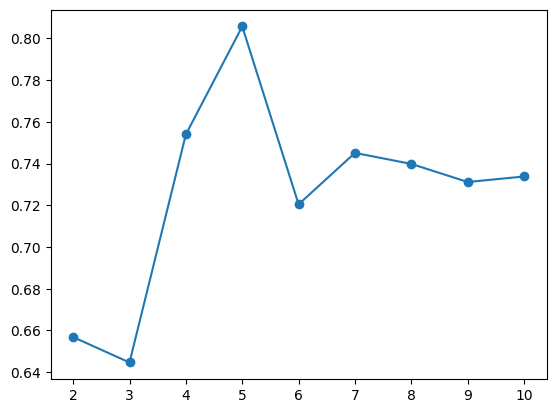

In [40]:
# 실루엣 분석 그래프 그리기
plt.plot(range(2, 11), silhouette_scores, marker='o')

In [41]:
# parameters
best_k = 2 # centroid의 best 개수 -> elbow, 실루엣 두 방법을 비교하여 선정한다.
abnormal = 1 # 시뮬레이션에서 이상치 판독 기준 개수
# Best k 적합하기
best = KMeans(
        n_clusters = best_k,    # 클러스터 수 설정
        init="random",   # 초기 중심점을 무작위로 선택
        n_init="auto",    # k-means 알고리즘 반복 실행 횟수 설정
        random_state=42
    ).fit(use_train)

In [43]:
use_train['kmeans_2'] = best.labels_

In [44]:
# parameters
best_k = 5 # centroid의 best 개수 -> elbow, 실루엣 두 방법을 비교하여 선정한다.
abnormal = 1 # 시뮬레이션에서 이상치 판독 기준 개수
# Best k 적합하기
best = KMeans(
        n_clusters = best_k,    # 클러스터 수 설정
        init="random",   # 초기 중심점을 무작위로 선택
        n_init="auto",    # k-means 알고리즘 반복 실행 횟수 설정
        random_state=42
    ).fit(use_train)

In [45]:
use_train['kmeans_5'] = best.labels_

In [54]:
a = pd.crosstab(use_train['kmeans_2'], use_train['target'])
a['total'] = a['AbNormal'] + a['Normal']
a['ratio'] = a['AbNormal']/a['total']
a

KeyError: 'AbNormal'

In [68]:
k = use_train.corr()[['kmeans_2', 'kmeans_5']].reset_index()
k

,index,kmeans_2,kmeans_5
68,Head Purge Position Z Collect Result_Fill1,-0.794097,0.448731
7,Dispense Volume(Stage3) Collect Result_Dam,-0.719121,0.576165
5,Dispense Volume(Stage1) Collect Result_Dam,-0.718794,0.575979
2,DISCHARGED TIME OF RESIN(Stage1) Collect Resul...,-0.701826,0.534140
4,DISCHARGED TIME OF RESIN(Stage3) Collect Resul...,-0.699870,0.533146
...,...,...,...
44,Stage3 Circle4 Distance Speed Collect Result_Dam,0.867661,-0.606549
48,Stage3 Line4 Distance Speed Collect Result_Dam,0.867661,-0.606549
46,Stage3 Line2 Distance Speed Collect Result_Dam,0.867661,-0.606549
74,kmeans_2,1.000000,-0.695502


In [76]:
import plotly.graph_objects as go

# Figure  생성
fig = go.Figure()

# Bar Trace 추가
k = k.sort_values('kmeans_2')
fig.add_trace(go.Bar(x = k['index'] , y = k['kmeans_2']))

fig.show()

In [77]:
# Figure  생성
fig = go.Figure()

fig.add_trace(go.Bar(x = k['index'] , y = k['kmeans_5']))

fig.show()

In [81]:
pd.crosstab(use_train['kmeans_2'], use_train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'])

HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,549.455276,549.544724,549.944724,549.955276,550.044724,550.055276,550.255276,550.444724,550.544724,550.655276,...,552.355276,552.544724,552.555276,552.644724,552.655276,552.744724,552.844724,552.955276,553.044724,553.144724
kmeans_2,,,,,,,,,,,,,,,,,,,,,
0,824,0,842,489,0,0,2349,446,0,1905,...,1054,1431,2352,20,1,968,494,26,446,475
1,0,26,0,0,7248,2,478,0,1260,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
pd.crosstab(use_train['kmeans_5'], use_train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'])

HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,549.455276,549.544724,549.944724,549.955276,550.044724,550.055276,550.255276,550.444724,550.544724,550.655276,...,552.355276,552.544724,552.555276,552.644724,552.655276,552.744724,552.844724,552.955276,553.044724,553.144724
kmeans_5,,,,,,,,,,,,,,,,,,,,,
0,0,26,0,0,3837,2,478,0,1260,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,2349,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,3411,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,824,0,842,489,0,0,0,446,0,1905,...,1054,1257,1684,20,1,968,0,26,446,475
4,0,0,0,0,0,0,0,0,0,0,...,0,174,668,0,0,0,494,0,0,0


<Axes: xlabel='HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', ylabel='Density'>

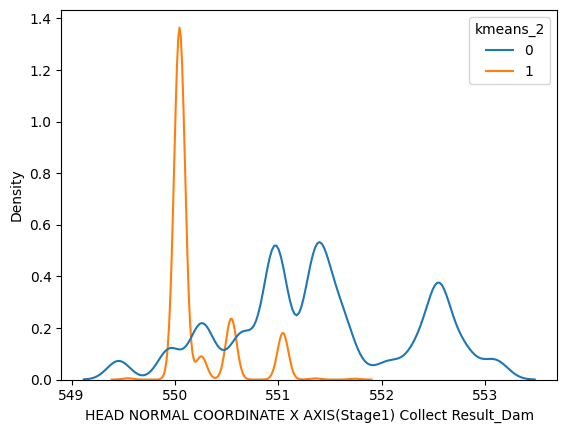

In [89]:
sns.kdeplot(data = use_train, x = 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', hue = 'kmeans_2')

<Axes: xlabel='HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', ylabel='Density'>

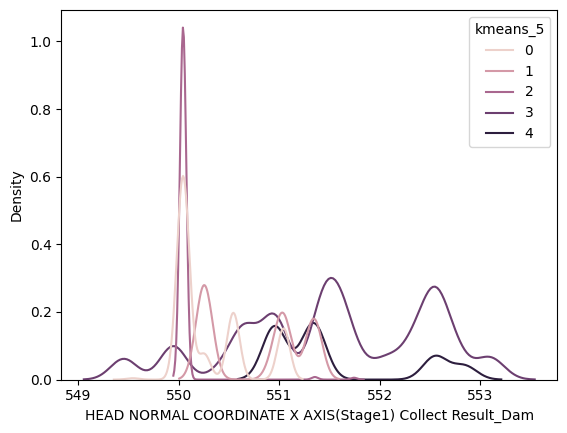

In [88]:
sns.kdeplot(data = use_train, x = 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', hue = 'kmeans_5')

In [90]:
train_noin[['kmeans_2', 'kmeans_5']] = use_train[['kmeans_2', 'kmeans_5']]

/tmp/ipykernel_9148/3651773053.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9148/3651773053.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [97]:
a = train_noin[[
    'kmeans_2',
    'kmeans_5',
    '1st Pressure Collect Result_AutoClave',
    '1st Pressure 1st Pressure Unit Time_AutoClave',
    '2nd Pressure Collect Result_AutoClave',
    '2nd Pressure Unit Time_AutoClave',
    '3rd Pressure Collect Result_AutoClave',
    '3rd Pressure Unit Time_AutoClave',
    'Chamber Temp. Collect Result_AutoClave',
    'Chamber Temp. Unit Time_AutoClave'
]]

In [101]:
a['kmeans_2'] = a['kmeans_2'].astype(str)
a['kmeans_5'] = a['kmeans_5'].astype(str)

/tmp/ipykernel_9148/1305025294.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9148/1305025294.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: >

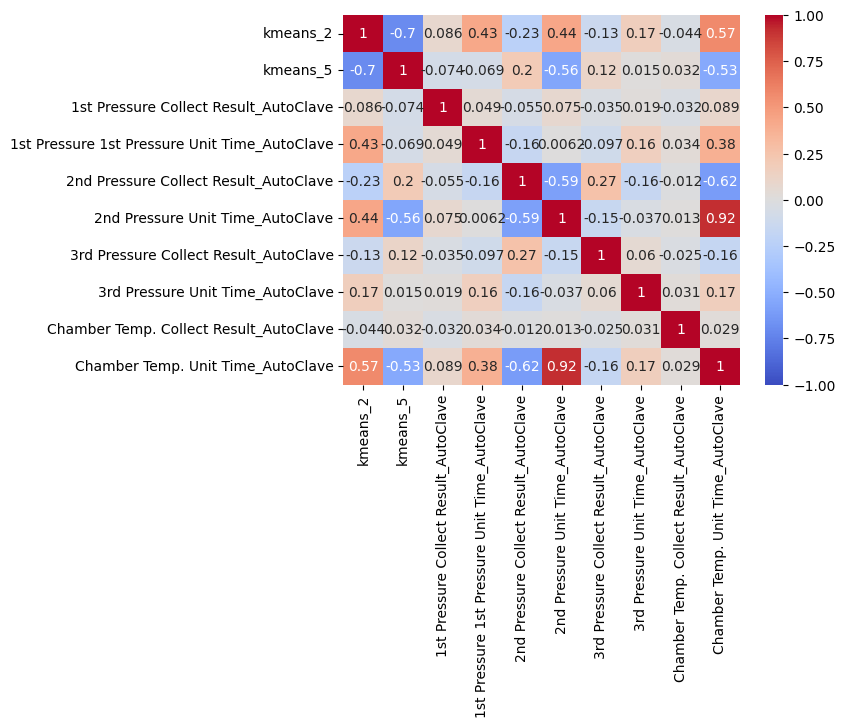

In [100]:
sns.heatmap(a.corr(), vmin = -1, vmax = 1, annot = True, cmap="coolwarm")

<Axes: xlabel='Chamber Temp. Unit Time_AutoClave', ylabel='Density'>

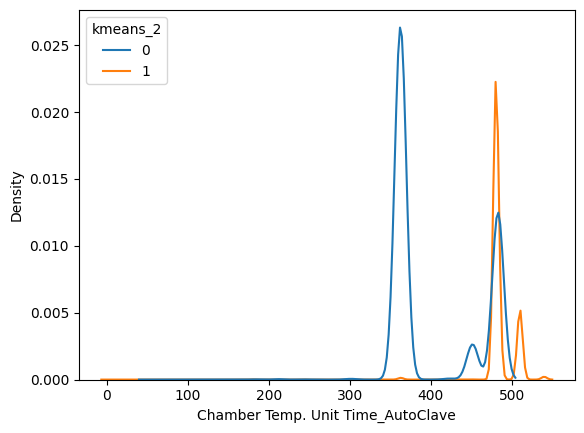

In [102]:
sns.kdeplot(data = a, x = 'Chamber Temp. Unit Time_AutoClave', hue = 'kmeans_2')

<Axes: xlabel='Chamber Temp. Unit Time_AutoClave', ylabel='Density'>

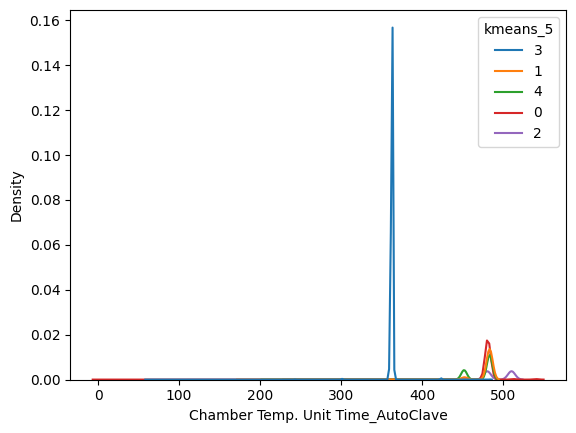

In [103]:
sns.kdeplot(data = a, x = 'Chamber Temp. Unit Time_AutoClave', hue = 'kmeans_5')